In [2]:
import cv2
from sklearn.preprocessing import normalize
from PIL import Image
from tf_unet import unet
from tf_unet import util

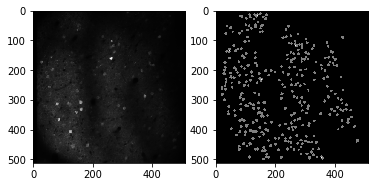

In [1]:
import json
import matplotlib.pyplot as plt
from numpy import array, zeros
from scipy.misc import imread
from glob import glob

# load the images
files = sorted(glob('images/*.tiff'))

imgs = array([imread(f) for f in files])
dims = imgs.shape[1:]

# load the regions (training data only)
with open('regions/regions.json') as f:
    regions = json.load(f)

def tomask(coords):
    mask = zeros(dims)
    mask[zip(*coords)] = 1
    return mask

masks = array([tomask(s['coordinates']) for s in regions])

# show the outputs
plt.figure()
plt.subplot(1, 2, 1)
plt.imshow(imgs.sum(axis=0), cmap='gray')
plt.subplot(1, 2, 2)
plt.imshow(masks.sum(axis=0), cmap='gray')
plt.show()

In [3]:
final = imgs.sum(axis=0)
masked = masks.sum(axis=0)
print(final.shape)
print(masked.shape)

(512, 512)
(512, 512)


In [4]:
import scipy.misc
scipy.misc.imsave('newdata/train.tif', final)
scipy.misc.imsave('newdata/train_mask.tif', masked)

In [11]:
from tf_unet import image_gen
from tf_unet import unet
from tf_unet import util
from tf_unet import image_util

In [16]:
data_provider = image_util.ImageDataProvider('newdata/*.tif')

Number of files used: 1


In [17]:
net = unet.Unet(channels=1, n_class=2, layers=3, features_root=16)

2018-03-03 17:43:09,488 Layers 3, features 16, filter size 3x3, pool size: 2x2


In [18]:
trainer = unet.Trainer(net, optimizer="momentum", opt_kwargs=dict(momentum=0.2))


In [19]:
path = trainer.train(data_provider, "./unet_trained", training_iters=20, epochs=10, display_step=2)

2018-03-03 17:43:13,764 Removing '/home/ankita/data/neurofinder.00.00/prediction'
2018-03-03 17:43:13,764 Removing '/home/ankita/data/neurofinder.00.00/unet_trained'
2018-03-03 17:43:13,765 Allocating '/home/ankita/data/neurofinder.00.00/prediction'
2018-03-03 17:43:13,765 Allocating '/home/ankita/data/neurofinder.00.00/unet_trained'
2018-03-03 17:43:16,535 Verification error= 67.9%, loss= 0.6992
2018-03-03 17:43:16,787 Start optimization
2018-03-03 17:43:18,875 Iter 0, Minibatch Loss= 0.6027, Training Accuracy= 0.9040, Minibatch error= 9.6%
2018-03-03 17:43:22,267 Iter 2, Minibatch Loss= 0.4917, Training Accuracy= 0.9040, Minibatch error= 9.6%
2018-03-03 17:43:25,713 Iter 4, Minibatch Loss= 0.3983, Training Accuracy= 0.9040, Minibatch error= 9.6%
2018-03-03 17:43:29,113 Iter 6, Minibatch Loss= 0.3297, Training Accuracy= 0.9040, Minibatch error= 9.6%
2018-03-03 17:43:32,411 Iter 8, Minibatch Loss= 0.3156, Training Accuracy= 0.9040, Minibatch error= 9.6%
2018-03-03 17:43:35,688 Iter 10,

In [22]:
x_test, y_test = data_provider(1)

In [23]:
prediction = net.predict("./unet_trained/model.cpkt", x_test)

INFO:tensorflow:Restoring parameters from ./unet_trained/model.cpkt


2018-03-03 17:52:49,806 Restoring parameters from ./unet_trained/model.cpkt
2018-03-03 17:52:49,907 Model restored from file: ./unet_trained/model.cpkt


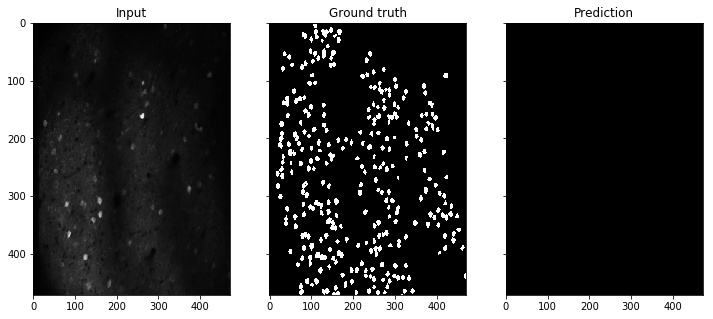

In [27]:
fig, ax = plt.subplots(1, 3, sharex=True, sharey=True, figsize=(12,5))
ax[0].imshow(x_test[0,...,0], aspect="auto",cmap='gray')
ax[1].imshow(y_test[0,...,1], aspect="auto",cmap='gray')
mask = prediction[0,...,1] > 0.9
ax[2].imshow(mask, aspect="auto",cmap='gray')
ax[0].set_title("Input")
ax[1].set_title("Ground truth")
ax[2].set_title("Prediction")
plt.show()
